In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Comment this to use gpu

In [9]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
from torch_geometric.utils import to_dense_batch, to_dense_adj, k_hop_subgraph, to_networkx
import torch
import jax
import numpy as np
import jax.numpy as jnp
import tensorcircuit as tc
from tqdm import tqdm
from time import time
from itertools import zip_longest
import networkx as nx

torch.set_float32_matmul_precision("medium")
K = tc.set_backend("jax")
print(tc.__version__)

0.10.0


In [10]:
jax.devices()

[CpuDevice(id=0)]

In [11]:
DATASET_PATH = "./data"
tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH,
                                                name="MUTAG")
tu_dataset.shuffle()

import torch_geometric.transforms as T
transform = T.Compose([T.Pad(28, 66)])
tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="MUTAG", transform=transform)
tu_dataset.get_summary()

TUDataset (#graphs=188):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |       28 |       66 |
| std        |        0 |        0 |
| min        |       28 |       66 |
| quantile25 |       28 |       66 |
| median     |       28 |       66 |
| quantile75 |       28 |       66 |
| max        |       28 |       66 |
+------------+----------+----------+

In [12]:
tu_dataset.get_summary().num_nodes.max

28.0

In [13]:
k = 3
max_nodes = 28
n_features = tu_dataset.num_features

In [53]:
n_features

7

In [58]:
s = time()

temp_dataset = []

max_ego_nodes = 0

for data in tu_dataset:
    n_nodes = data.num_nodes
    
    ego_nodes = []
    for node in range(n_nodes):
        
        try:
            subset, edge_index, _, _ = k_hop_subgraph(node,
                                                  k,
                                                  data.edge_index,
                                                  directed=False)
        except:
            subset = []
            edge_index = torch.tensor([])
            
        n_subset_nodes = len(subset)
        
        if n_subset_nodes:
            G = nx.Graph()
            G.add_edges_from(edge_index.numpy().T)
            paths = nx.single_source_shortest_path_length(G, node, cutoff=k)

            nodes = np.array(list(paths.keys()))
            dists = np.array(list(paths.values()))

            hop_nodes = [
                [node] + list(nodes[np.where(dists == hop)[0]]) for hop in range(1, k + 1)
            ]
            
            hop_nodes = np.array(list(zip_longest(*hop_nodes, fillvalue=max_nodes+1))).T
        else:
            dists = np.array([])
            hop_nodes = np.array([np.array([])]*k)
            
        ego_nodes.append(hop_nodes)

        max_ego_nodes = max(max_ego_nodes, hop_nodes.shape[-1])

    temp_dataset.append(ego_nodes)
    
e = time()
print("Duration:", e-s)

Duration: 11.262277841567993


In [15]:
s = time()
ego_dataset = np.stack([np.stack([
        np.pad(ego_nodes, ((0, 0), (0, max_ego_nodes - ego_nodes.shape[-1])),
               constant_values=max_nodes+1) for ego_nodes in data
    ]) for data in temp_dataset]).astype(np.int32)
e = time()
print("Duration:", e-s)

Duration: 0.16064238548278809


In [16]:
ego_dataset.shape

(188, 28, 3, 9)

In [17]:
from torch.utils.data import Dataset

class MUTAGDataset(Dataset):
    """Face Landmarks dataset."""
    def __init__(self):
        pass
    
    def __len__(self):
        return len(tu_dataset)

    def __getitem__(self, idx):
        data = tu_dataset[idx]
        return {
            'x': data.x,
            'ego_graphs': torch.tensor(ego_dataset[idx]),
            'y': data.y
        }

In [18]:
import ml_collections

def get_config():
    """Get the default hyperparameter configuration."""
    config = ml_collections.ConfigDict()

    config.learning_rate = 0.001
    config.batch_size = 16
    config.num_epochs = 200
    return config

In [19]:
from torch.utils.data import random_split, DataLoader

def my_collate_fn(batch):
    x = []
    y = []
    ego_graphs = []
    for data in batch:
        x += [data['x']]
        y += [data['y']]
        ego_graphs += [data['ego_graphs']]
    
    x = torch.stack(x)
    y = torch.stack(y)
    ego_graphs = torch.stack(ego_graphs)
    return x, y, ego_graphs


def get_loaders(config):
    split = 188
    mutag_ds = MUTAGDataset()

    split_a_size = split
    split_b_size = len(mutag_ds) - split_a_size

    train_dataset, test_dataset = random_split(
        mutag_ds, [split_a_size, split_b_size],
        generator=torch.Generator().manual_seed(42))

    batch_size = config.batch_size
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=my_collate_fn,
                              pin_memory=True,
                              num_workers=8)

    val_loader = DataLoader(test_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=my_collate_fn,
                            pin_memory=True,
                            num_workers=8)
    
    return train_loader, val_loader

In [20]:
import optax
from typing import Callable


def graph_circ(ego_graphs, x, lmbd, theta):
    n_qubits = ego_graphs.shape[-1] 
    n_features = x.shape[-1]
    n_hops = ego_graphs.shape[-2]
    steps = n_features // 3
    readout = n_qubits
    c = tc.Circuit(n_qubits + 1)
    
#     # Cluster state
#     for q in range(n_qubits):
#         c.H(q)
#     for q in range(n_qubits - 1):
#         c.cz(q, q+1)
        
#     c.cz(n_qubits - 1, 0)
    
#     # prepare readout
#     c.X(readout)
#     c.H(readout)
    
#     # circuit
#     for hop in range(n_hops):
#         inputs = jnp.take(x, ego_graphs[hop], axis=0)
#         inputs = jnp.nan_to_num(inputs)
#         print(x.shape, ego_graphs[hop].shape, inputs.shape, lmbd[hop].shape)
#         inputs = jnp.multiply(inputs, lmbd[hop])        
        
#         for q in range(n_qubits):
#             for i in range(steps):
#                 c.rx(q, theta=inputs[q, 3*i])
#                 c.ry(q, theta=inputs[q, 3*i + 1])
#                 c.rz(q, theta=inputs[q, 3*i + 2])
            
#         for q in range(n_qubits):
#             c.rxx(q, readout, theta=theta[hop, q])
    
#     # prepare readout
#     c.H(readout)
#     return K.real(c.expectation_ps(z=[readout]))
    
    # Paper's implementation
    for hop in range(n_hops):
        inputs = jnp.take(x, ego_graphs[hop], axis=0)
        inputs = jnp.nan_to_num(inputs)
        inputs = jnp.multiply(inputs, lmbd[hop])        
        
        for q in range(n_qubits):
            for i in range(steps):
                c.rx(q, theta=inputs[q, 3*i])
                c.ry(q, theta=inputs[q, 3*i + 1])
                c.rz(q, theta=inputs[q, 3*i + 2])
            
            c.rx(q, theta=theta[hop, q, 0])
            c.ry(q, theta=theta[hop, q, 1])
            c.rz(q, theta=theta[hop, q, 2])
            
        for q in range(n_qubits - 1):
            c.cz(i, i + 1)
            
    return K.real(jnp.array([c.expectation_ps(z=[i]) for i in range(n_qubits)]))
    
qpred_vmap = K.vmap(K.jit(graph_circ), vectorized_argnums=(0, ))

In [46]:
n_qubits = max_ego_nodes
n_hops = k

key = jax.random.PRNGKey(0)
key, *subkeys = jax.random.split(key, num=5)

lmbd = jax.random.uniform(subkeys[0], (n_hops, n_qubits, n_features))
theta = jax.random.uniform(subkeys[1], (n_hops, n_qubits, 3)) # paper's implementation
# theta = jax.random.uniform(subkeys[1], (n_hops, n_qubits))
w = jax.random.uniform(subkeys[2], (2, n_qubits)) # paper's implementation
b = jax.random.uniform(subkeys[3], (2,)) # paper's implementation
# w = jax.random.uniform(subkeys[2], (2, max_nodes))
# b = jax.random.uniform(subkeys[3], (2,))

params = {'lmbd': lmbd, 'theta': theta, 'w': w, 'b': b}

config = get_config()
optimizer = optax.adam(learning_rate=config.learning_rate)
opt_state = optimizer.init(params)

In [56]:
next(iter(train_loader))[0].shape

torch.Size([16, 28, 7])

In [48]:
def loss_fn(params, x, y, ego_graphs):
    res = qpred_vmap(ego_graphs, x, params['lmbd'], params['theta'])
    print(res.shape)
#     res = res.reshape(-1, )
    res = jnp.mean(res, axis=0) # paper's implementation
    print(res.shape)
    res = jnp.dot(params['w'], res) + params['b']
    logits = res
    one_hot = jax.nn.one_hot(y, 2).reshape(-1, )
    loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot)
    return loss, logits

In [49]:
qml_vvag = K.vectorized_value_and_grad(
    loss_fn, argnums=0, vectorized_argnums=(1, 2, 3), has_aux=True
)
qml_vvag = K.jit(qml_vvag)

In [50]:
dummy_x = jnp.ones([1, max_nodes, 7])
dummy_y = jnp.ones([1, 1])
dummy_ego_graphs = jnp.ones([1, max_nodes, k, max_ego_nodes]).astype(jnp.int32)

s = time()
qml_vvag(params, dummy_x, dummy_y, dummy_ego_graphs)
e = time()
print("Duration:", e-s)

(28, 9)
(9,)
Duration: 69.32015466690063


In [51]:
## train_loader, val_loader = get_loaders(config)
losses = []
accs = []
for epoch in range(1, config.num_epochs + 1):

    epoch_loss = []
    epoch_accuracy = []
    
    with tqdm(train_loader, unit='batch') as tepoch:
        
        s = time()
        for x, y, ego_graphs in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            x = x.numpy()
            y = y.numpy()
            
            ego_graphs = ego_graphs.numpy().astype(np.int32)

            (loss, logits), grads = qml_vvag(params, x, y, ego_graphs)
            
            accuracy = jnp.mean(jnp.argmax(logits, -1) == y)

            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)

            epoch_loss.append(jnp.mean(loss))
            epoch_accuracy.append(accuracy)
        
        e = time()
        
        train_loss = np.mean(epoch_loss)
        train_accuracy = np.mean(epoch_accuracy)
        
        print(
        f'epoch: {epoch:3d}',
        f'train_loss: {train_loss:.4f}, train_acc: {train_accuracy:.4f}',
        f'epoch time: {e-s:.4f}')
        
        losses.append(train_loss)
        accs.append(train_accuracy)
        
#         f'test_loss: {test_loss:.4f}, test_accuracy: {test_accuracy:.4f}')

Epoch 1:   0%|                                        | 0/12 [00:00<?, ?batch/s]

(28, 9)
(9,)


Epoch 1:  92%|████████████████████████████▍  | 11/12 [01:23<00:00,  1.20batch/s]

(28, 9)
(9,)


Epoch 1: 100%|███████████████████████████████| 12/12 [02:47<00:00, 13.95s/batch]


epoch:   1 train_loss: 0.6799, train_acc: 0.6597 epoch time: 167.3735


Epoch 2: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.07batch/s]


epoch:   2 train_loss: 0.6591, train_acc: 0.6615 epoch time: 1.9773


Epoch 3: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.06batch/s]


epoch:   3 train_loss: 0.6446, train_acc: 0.6649 epoch time: 1.9806


Epoch 4: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.10batch/s]


epoch:   4 train_loss: 0.6400, train_acc: 0.6597 epoch time: 1.9668


Epoch 5: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.08batch/s]


epoch:   5 train_loss: 0.6288, train_acc: 0.6667 epoch time: 1.9752


Epoch 6: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.36batch/s]


epoch:   6 train_loss: 0.6267, train_acc: 0.6632 epoch time: 1.8876


Epoch 7: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.16batch/s]


epoch:   7 train_loss: 0.6226, train_acc: 0.6649 epoch time: 1.9477


Epoch 8: 100%|███████████████████████████████| 12/12 [00:02<00:00,  4.82batch/s]


epoch:   8 train_loss: 0.6200, train_acc: 0.6632 epoch time: 2.4890


Epoch 9: 100%|███████████████████████████████| 12/12 [00:02<00:00,  4.85batch/s]


epoch:   9 train_loss: 0.6132, train_acc: 0.6684 epoch time: 2.4742


Epoch 10: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.75batch/s]


epoch:  10 train_loss: 0.6096, train_acc: 0.6684 epoch time: 2.5250


Epoch 11: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.77batch/s]


epoch:  11 train_loss: 0.6106, train_acc: 0.6615 epoch time: 2.5145


Epoch 12: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.07batch/s]


epoch:  12 train_loss: 0.6042, train_acc: 0.6649 epoch time: 2.3683


Epoch 13: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.02batch/s]


epoch:  13 train_loss: 0.6000, train_acc: 0.6649 epoch time: 2.3909


Epoch 14: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.98batch/s]


epoch:  14 train_loss: 0.5943, train_acc: 0.6684 epoch time: 2.4106


Epoch 15: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.97batch/s]


epoch:  15 train_loss: 0.5894, train_acc: 0.6684 epoch time: 2.4174


Epoch 16: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.04batch/s]


epoch:  16 train_loss: 0.5870, train_acc: 0.6649 epoch time: 2.3814


Epoch 17: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.11batch/s]


epoch:  17 train_loss: 0.5799, train_acc: 0.6684 epoch time: 2.3481


Epoch 18: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.94batch/s]


epoch:  18 train_loss: 0.5794, train_acc: 0.6615 epoch time: 2.0219


Epoch 19: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.02batch/s]


epoch:  19 train_loss: 0.5712, train_acc: 0.6667 epoch time: 2.3904


Epoch 20: 100%|██████████████████████████████| 12/12 [00:02<00:00,  4.76batch/s]


epoch:  20 train_loss: 0.5676, train_acc: 0.6649 epoch time: 2.5230


Epoch 21: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.05batch/s]


epoch:  21 train_loss: 0.5612, train_acc: 0.6667 epoch time: 2.3777


Epoch 22: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.58batch/s]


epoch:  22 train_loss: 0.5572, train_acc: 0.6615 epoch time: 2.1511


Epoch 23: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.32batch/s]


epoch:  23 train_loss: 0.5532, train_acc: 0.6615 epoch time: 1.8996


Epoch 24: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.94batch/s]


epoch:  24 train_loss: 0.5439, train_acc: 0.6684 epoch time: 2.0202


Epoch 25: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.07batch/s]


epoch:  25 train_loss: 0.5413, train_acc: 0.6632 epoch time: 1.9784


Epoch 26: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.93batch/s]


epoch:  26 train_loss: 0.5341, train_acc: 0.6649 epoch time: 2.0253


Epoch 27: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.26batch/s]


epoch:  27 train_loss: 0.5282, train_acc: 0.6684 epoch time: 1.9172


Epoch 28: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.62batch/s]


epoch:  28 train_loss: 0.5228, train_acc: 0.6649 epoch time: 1.8146


Epoch 29: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.42batch/s]


epoch:  29 train_loss: 0.5181, train_acc: 0.6531 epoch time: 1.8698


Epoch 30: 100%|██████████████████████████████| 12/12 [00:02<00:00,  6.00batch/s]


epoch:  30 train_loss: 0.5104, train_acc: 0.6476 epoch time: 2.0022


Epoch 31: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.19batch/s]


epoch:  31 train_loss: 0.5071, train_acc: 0.6479 epoch time: 1.9388


Epoch 32: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.51batch/s]


epoch:  32 train_loss: 0.5019, train_acc: 0.6404 epoch time: 1.8447


Epoch 33: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.38batch/s]


epoch:  33 train_loss: 0.5000, train_acc: 0.6311 epoch time: 1.8805


Epoch 34: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.46batch/s]


epoch:  34 train_loss: 0.4946, train_acc: 0.6195 epoch time: 1.8590


Epoch 35: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.21batch/s]


epoch:  35 train_loss: 0.4908, train_acc: 0.6184 epoch time: 1.9329


Epoch 36: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.26batch/s]


epoch:  36 train_loss: 0.4813, train_acc: 0.6162 epoch time: 1.9166


Epoch 37: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.69batch/s]


epoch:  37 train_loss: 0.4763, train_acc: 0.6160 epoch time: 1.7944


Epoch 38: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.55batch/s]


epoch:  38 train_loss: 0.4719, train_acc: 0.6059 epoch time: 1.8336


Epoch 39: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.46batch/s]


epoch:  39 train_loss: 0.4669, train_acc: 0.6026 epoch time: 1.8588


Epoch 40: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.31batch/s]


epoch:  40 train_loss: 0.4641, train_acc: 0.6000 epoch time: 1.9028


Epoch 41: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.47batch/s]


epoch:  41 train_loss: 0.4601, train_acc: 0.5938 epoch time: 1.8561


Epoch 42: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.14batch/s]


epoch:  42 train_loss: 0.4561, train_acc: 0.5958 epoch time: 1.9561


Epoch 43: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.98batch/s]


epoch:  43 train_loss: 0.4532, train_acc: 0.5947 epoch time: 2.0067


Epoch 44: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.24batch/s]


epoch:  44 train_loss: 0.4491, train_acc: 0.5934 epoch time: 1.9234


Epoch 45: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.33batch/s]


epoch:  45 train_loss: 0.4446, train_acc: 0.5964 epoch time: 1.8978


Epoch 46: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.10batch/s]


epoch:  46 train_loss: 0.4394, train_acc: 0.5929 epoch time: 1.9693


Epoch 47: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.01batch/s]


epoch:  47 train_loss: 0.4405, train_acc: 0.5988 epoch time: 1.9972


Epoch 48: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.47batch/s]


epoch:  48 train_loss: 0.4329, train_acc: 0.5972 epoch time: 1.8570


Epoch 49: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.27batch/s]


epoch:  49 train_loss: 0.4346, train_acc: 0.6151 epoch time: 1.9145


Epoch 50: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.30batch/s]


epoch:  50 train_loss: 0.4295, train_acc: 0.5850 epoch time: 1.9063


Epoch 51: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.27batch/s]


epoch:  51 train_loss: 0.4273, train_acc: 0.5808 epoch time: 1.9144


Epoch 52: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.28batch/s]


epoch:  52 train_loss: 0.4232, train_acc: 0.6000 epoch time: 1.9120


Epoch 53: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.56batch/s]


epoch:  53 train_loss: 0.4178, train_acc: 0.5795 epoch time: 1.8311


Epoch 54: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.29batch/s]


epoch:  54 train_loss: 0.4181, train_acc: 0.5833 epoch time: 1.9102


Epoch 55: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.36batch/s]


epoch:  55 train_loss: 0.4145, train_acc: 0.6141 epoch time: 1.8868


Epoch 56: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.22batch/s]


epoch:  56 train_loss: 0.4148, train_acc: 0.5954 epoch time: 1.9299


Epoch 57: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.22batch/s]


epoch:  57 train_loss: 0.4138, train_acc: 0.5906 epoch time: 1.9303


Epoch 58: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.26batch/s]


epoch:  58 train_loss: 0.4107, train_acc: 0.5749 epoch time: 1.9171


Epoch 59: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.23batch/s]


epoch:  59 train_loss: 0.4066, train_acc: 0.5775 epoch time: 1.9262


Epoch 60: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.31batch/s]


epoch:  60 train_loss: 0.4068, train_acc: 0.5902 epoch time: 1.9028


Epoch 61: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.15batch/s]


epoch:  61 train_loss: 0.4025, train_acc: 0.5977 epoch time: 1.9532


Epoch 62: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.29batch/s]


epoch:  62 train_loss: 0.4003, train_acc: 0.5901 epoch time: 1.9071


Epoch 63: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.24batch/s]


epoch:  63 train_loss: 0.3981, train_acc: 0.6026 epoch time: 1.9247


Epoch 64: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.21batch/s]


epoch:  64 train_loss: 0.3994, train_acc: 0.5867 epoch time: 1.9321


Epoch 65: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.25batch/s]


epoch:  65 train_loss: 0.3991, train_acc: 0.5905 epoch time: 1.9208


Epoch 66: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.19batch/s]


epoch:  66 train_loss: 0.3935, train_acc: 0.5999 epoch time: 1.9400


Epoch 67: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.11batch/s]


epoch:  67 train_loss: 0.3946, train_acc: 0.5889 epoch time: 1.9631


Epoch 68: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.79batch/s]


epoch:  68 train_loss: 0.3914, train_acc: 0.5972 epoch time: 2.0727


Epoch 69: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.20batch/s]


epoch:  69 train_loss: 0.3899, train_acc: 0.5921 epoch time: 1.9363


Epoch 70: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.49batch/s]


epoch:  70 train_loss: 0.3898, train_acc: 0.5845 epoch time: 1.8505


Epoch 71: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.70batch/s]


epoch:  71 train_loss: 0.3874, train_acc: 0.5888 epoch time: 1.7931


Epoch 72: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.52batch/s]


epoch:  72 train_loss: 0.3867, train_acc: 0.5909 epoch time: 1.8412


Epoch 73: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.63batch/s]


epoch:  73 train_loss: 0.3868, train_acc: 0.5953 epoch time: 1.8103


Epoch 74: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.66batch/s]


epoch:  74 train_loss: 0.3843, train_acc: 0.6000 epoch time: 1.8013


Epoch 75: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.75batch/s]


epoch:  75 train_loss: 0.3819, train_acc: 0.5782 epoch time: 1.7791


Epoch 76: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.68batch/s]


epoch:  76 train_loss: 0.3844, train_acc: 0.5877 epoch time: 1.7959


Epoch 77: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.62batch/s]


epoch:  77 train_loss: 0.3826, train_acc: 0.5816 epoch time: 1.8138


Epoch 78: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.67batch/s]


epoch:  78 train_loss: 0.3790, train_acc: 0.5872 epoch time: 1.7997


Epoch 79: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.58batch/s]


epoch:  79 train_loss: 0.3813, train_acc: 0.5953 epoch time: 1.8248


Epoch 80: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.78batch/s]


epoch:  80 train_loss: 0.3811, train_acc: 0.5979 epoch time: 1.7714


Epoch 81: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.26batch/s]


epoch:  81 train_loss: 0.3801, train_acc: 0.5792 epoch time: 1.9188


Epoch 82: 100%|██████████████████████████████| 12/12 [00:02<00:00,  5.81batch/s]


epoch:  82 train_loss: 0.3772, train_acc: 0.6057 epoch time: 2.0653


Epoch 83: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.10batch/s]


epoch:  83 train_loss: 0.3773, train_acc: 0.5922 epoch time: 1.9668


Epoch 84: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.29batch/s]


epoch:  84 train_loss: 0.3784, train_acc: 0.6014 epoch time: 1.9098


Epoch 85: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.45batch/s]


epoch:  85 train_loss: 0.3733, train_acc: 0.5864 epoch time: 1.8620


Epoch 86: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.58batch/s]


epoch:  86 train_loss: 0.3743, train_acc: 0.5964 epoch time: 1.8252


Epoch 87: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.51batch/s]


epoch:  87 train_loss: 0.3753, train_acc: 0.5956 epoch time: 1.8432


Epoch 88: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.51batch/s]


epoch:  88 train_loss: 0.3726, train_acc: 0.5710 epoch time: 1.8449


Epoch 89: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.38batch/s]


epoch:  89 train_loss: 0.3734, train_acc: 0.5815 epoch time: 1.8824


Epoch 90: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.16batch/s]


epoch:  90 train_loss: 0.3746, train_acc: 0.5853 epoch time: 1.9479


Epoch 91: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.08batch/s]


epoch:  91 train_loss: 0.3710, train_acc: 0.5876 epoch time: 1.9731


Epoch 92: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.17batch/s]


epoch:  92 train_loss: 0.3712, train_acc: 0.5781 epoch time: 1.9456


Epoch 93: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.20batch/s]


epoch:  93 train_loss: 0.3687, train_acc: 0.5909 epoch time: 1.9355


Epoch 94: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.46batch/s]


epoch:  94 train_loss: 0.3678, train_acc: 0.5811 epoch time: 1.8598


Epoch 95: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.25batch/s]


epoch:  95 train_loss: 0.3700, train_acc: 0.5744 epoch time: 1.9217


Epoch 96: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.31batch/s]


epoch:  96 train_loss: 0.3698, train_acc: 0.5938 epoch time: 1.9013


Epoch 97: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.41batch/s]


epoch:  97 train_loss: 0.3729, train_acc: 0.5724 epoch time: 1.8716


Epoch 98: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.38batch/s]


epoch:  98 train_loss: 0.3658, train_acc: 0.6135 epoch time: 1.8831


Epoch 99: 100%|██████████████████████████████| 12/12 [00:01<00:00,  6.45batch/s]


epoch:  99 train_loss: 0.3692, train_acc: 0.5894 epoch time: 1.8619


Epoch 100: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.19batch/s]


epoch: 100 train_loss: 0.3655, train_acc: 0.5838 epoch time: 1.9393


Epoch 101: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.25batch/s]


epoch: 101 train_loss: 0.3642, train_acc: 0.6005 epoch time: 1.9192


Epoch 102: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.27batch/s]


epoch: 102 train_loss: 0.3645, train_acc: 0.5875 epoch time: 1.9144


Epoch 103: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.10batch/s]


epoch: 103 train_loss: 0.3659, train_acc: 0.5822 epoch time: 1.9679


Epoch 104: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.81batch/s]


epoch: 104 train_loss: 0.3636, train_acc: 0.5924 epoch time: 2.0662


Epoch 105: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.92batch/s]


epoch: 105 train_loss: 0.3617, train_acc: 0.6070 epoch time: 2.0267


Epoch 106: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.12batch/s]


epoch: 106 train_loss: 0.3606, train_acc: 0.5951 epoch time: 1.9604


Epoch 107: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.72batch/s]


epoch: 107 train_loss: 0.3664, train_acc: 0.5770 epoch time: 2.0978


Epoch 108: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.00batch/s]


epoch: 108 train_loss: 0.3604, train_acc: 0.5803 epoch time: 1.9992


Epoch 109: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.96batch/s]


epoch: 109 train_loss: 0.3605, train_acc: 0.5896 epoch time: 2.0143


Epoch 110: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.76batch/s]


epoch: 110 train_loss: 0.3632, train_acc: 0.5918 epoch time: 2.0850


Epoch 111: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.32batch/s]


epoch: 111 train_loss: 0.3565, train_acc: 0.5905 epoch time: 1.8984


Epoch 112: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.24batch/s]


epoch: 112 train_loss: 0.3628, train_acc: 0.5964 epoch time: 1.9252


Epoch 113: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.40batch/s]


epoch: 113 train_loss: 0.3575, train_acc: 0.5838 epoch time: 1.8767


Epoch 114: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.49batch/s]


epoch: 114 train_loss: 0.3590, train_acc: 0.5849 epoch time: 1.8513


Epoch 115: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.10batch/s]


epoch: 115 train_loss: 0.3577, train_acc: 0.5762 epoch time: 1.9688


Epoch 116: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.81batch/s]


epoch: 116 train_loss: 0.3559, train_acc: 0.5778 epoch time: 2.0649


Epoch 117: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.90batch/s]


epoch: 117 train_loss: 0.3632, train_acc: 0.5939 epoch time: 2.0351


Epoch 118: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.36batch/s]


epoch: 118 train_loss: 0.3565, train_acc: 0.5993 epoch time: 1.8863


Epoch 119: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.70batch/s]


epoch: 119 train_loss: 0.3556, train_acc: 0.5837 epoch time: 2.1068


Epoch 120: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.13batch/s]


epoch: 120 train_loss: 0.3593, train_acc: 0.5730 epoch time: 1.9573


Epoch 121: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.32batch/s]


epoch: 121 train_loss: 0.3541, train_acc: 0.5846 epoch time: 1.9005


Epoch 122: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.26batch/s]


epoch: 122 train_loss: 0.3541, train_acc: 0.5829 epoch time: 1.9187


Epoch 123: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.19batch/s]


epoch: 123 train_loss: 0.3587, train_acc: 0.5823 epoch time: 1.9384


Epoch 124: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.02batch/s]


epoch: 124 train_loss: 0.3555, train_acc: 0.5762 epoch time: 1.9944


Epoch 125: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.01batch/s]


epoch: 125 train_loss: 0.3556, train_acc: 0.6035 epoch time: 1.9989


Epoch 126: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.69batch/s]


epoch: 126 train_loss: 0.3564, train_acc: 0.5951 epoch time: 2.1102


Epoch 127: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.41batch/s]


epoch: 127 train_loss: 0.3589, train_acc: 0.5796 epoch time: 1.8719


Epoch 128: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.39batch/s]


epoch: 128 train_loss: 0.3548, train_acc: 0.5752 epoch time: 1.8786


Epoch 129: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.43batch/s]


epoch: 129 train_loss: 0.3547, train_acc: 0.5849 epoch time: 1.8668


Epoch 130: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.07batch/s]


epoch: 130 train_loss: 0.3531, train_acc: 0.5770 epoch time: 1.9793


Epoch 131: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.74batch/s]


epoch: 131 train_loss: 0.3516, train_acc: 0.5804 epoch time: 2.0912


Epoch 132: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.43batch/s]


epoch: 132 train_loss: 0.3536, train_acc: 0.5827 epoch time: 1.8673


Epoch 133: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.33batch/s]


epoch: 133 train_loss: 0.3475, train_acc: 0.5947 epoch time: 1.8968


Epoch 134: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.42batch/s]


epoch: 134 train_loss: 0.3536, train_acc: 0.5928 epoch time: 1.8698


Epoch 135: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.54batch/s]


epoch: 135 train_loss: 0.3547, train_acc: 0.5905 epoch time: 1.8350


Epoch 136: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.84batch/s]


epoch: 136 train_loss: 0.3506, train_acc: 0.5872 epoch time: 2.0553


Epoch 137: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.22batch/s]


epoch: 137 train_loss: 0.3504, train_acc: 0.5807 epoch time: 1.9293


Epoch 138: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.29batch/s]


epoch: 138 train_loss: 0.3530, train_acc: 0.5828 epoch time: 1.9090


Epoch 139: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.78batch/s]


epoch: 139 train_loss: 0.3480, train_acc: 0.5803 epoch time: 1.7718


Epoch 140: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.67batch/s]


epoch: 140 train_loss: 0.3481, train_acc: 0.5831 epoch time: 1.7990


Epoch 141: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.33batch/s]


epoch: 141 train_loss: 0.3466, train_acc: 0.5782 epoch time: 1.8973


Epoch 142: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.73batch/s]


epoch: 142 train_loss: 0.3517, train_acc: 0.6035 epoch time: 2.0936


Epoch 143: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.28batch/s]


epoch: 143 train_loss: 0.3468, train_acc: 0.5854 epoch time: 1.9117


Epoch 144: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.20batch/s]


epoch: 144 train_loss: 0.3491, train_acc: 0.5993 epoch time: 1.9368


Epoch 145: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.88batch/s]


epoch: 145 train_loss: 0.3448, train_acc: 0.5886 epoch time: 2.0433


Epoch 146: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.31batch/s]


epoch: 146 train_loss: 0.3485, train_acc: 0.5888 epoch time: 2.2621


Epoch 147: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.65batch/s]


epoch: 147 train_loss: 0.3467, train_acc: 0.5827 epoch time: 2.1244


Epoch 148: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.23batch/s]


epoch: 148 train_loss: 0.3535, train_acc: 0.5907 epoch time: 1.9271


Epoch 149: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.46batch/s]


epoch: 149 train_loss: 0.3480, train_acc: 0.5859 epoch time: 1.8590


Epoch 150: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.49batch/s]


epoch: 150 train_loss: 0.3454, train_acc: 0.5908 epoch time: 1.8510


Epoch 151: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.39batch/s]


epoch: 151 train_loss: 0.3495, train_acc: 0.5895 epoch time: 1.8792


Epoch 152: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.02batch/s]


epoch: 152 train_loss: 0.3430, train_acc: 0.5801 epoch time: 1.9950


Epoch 153: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.41batch/s]


epoch: 153 train_loss: 0.3483, train_acc: 0.5863 epoch time: 1.8719


Epoch 154: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.53batch/s]


epoch: 154 train_loss: 0.3434, train_acc: 0.5810 epoch time: 1.8391


Epoch 155: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.66batch/s]


epoch: 155 train_loss: 0.3466, train_acc: 0.5896 epoch time: 1.8035


Epoch 156: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.53batch/s]


epoch: 156 train_loss: 0.3437, train_acc: 0.5927 epoch time: 1.8389


Epoch 157: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.89batch/s]


epoch: 157 train_loss: 0.3482, train_acc: 0.6013 epoch time: 2.0373


Epoch 158: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.42batch/s]


epoch: 158 train_loss: 0.3437, train_acc: 0.5830 epoch time: 1.8709


Epoch 159: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.36batch/s]


epoch: 159 train_loss: 0.3426, train_acc: 0.5791 epoch time: 1.8889


Epoch 160: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.48batch/s]


epoch: 160 train_loss: 0.3500, train_acc: 0.5859 epoch time: 1.8526


Epoch 161: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.48batch/s]


epoch: 161 train_loss: 0.3456, train_acc: 0.5841 epoch time: 1.8531


Epoch 162: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.34batch/s]


epoch: 162 train_loss: 0.3466, train_acc: 0.5792 epoch time: 1.8942


Epoch 163: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.36batch/s]


epoch: 163 train_loss: 0.3412, train_acc: 0.5757 epoch time: 1.8886


Epoch 164: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.39batch/s]


epoch: 164 train_loss: 0.3434, train_acc: 0.5905 epoch time: 1.8786


Epoch 165: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.46batch/s]


epoch: 165 train_loss: 0.3468, train_acc: 0.5796 epoch time: 1.8578


Epoch 166: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.23batch/s]


epoch: 166 train_loss: 0.3414, train_acc: 0.6018 epoch time: 1.9261


Epoch 167: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.36batch/s]


epoch: 167 train_loss: 0.3460, train_acc: 0.5773 epoch time: 1.8871


Epoch 168: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.65batch/s]


epoch: 168 train_loss: 0.3440, train_acc: 0.5783 epoch time: 2.1266


Epoch 169: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.45batch/s]


epoch: 169 train_loss: 0.3448, train_acc: 0.5888 epoch time: 2.2044


Epoch 170: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.85batch/s]


epoch: 170 train_loss: 0.3452, train_acc: 0.5896 epoch time: 2.0520


Epoch 171: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.45batch/s]


epoch: 171 train_loss: 0.3443, train_acc: 0.5794 epoch time: 1.8604


Epoch 172: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.93batch/s]


epoch: 172 train_loss: 0.3514, train_acc: 0.5964 epoch time: 2.0249


Epoch 173: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.12batch/s]


epoch: 173 train_loss: 0.3413, train_acc: 0.5885 epoch time: 1.9609


Epoch 174: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.29batch/s]


epoch: 174 train_loss: 0.3394, train_acc: 0.5979 epoch time: 1.9093


Epoch 175: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.03batch/s]


epoch: 175 train_loss: 0.3458, train_acc: 0.5992 epoch time: 1.9894


Epoch 176: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.64batch/s]


epoch: 176 train_loss: 0.3381, train_acc: 0.5809 epoch time: 2.1277


Epoch 177: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.03batch/s]


epoch: 177 train_loss: 0.3385, train_acc: 0.5803 epoch time: 1.9910


Epoch 178: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.14batch/s]


epoch: 178 train_loss: 0.3385, train_acc: 0.5924 epoch time: 1.9564


Epoch 179: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.46batch/s]


epoch: 179 train_loss: 0.3403, train_acc: 0.5827 epoch time: 1.8593


Epoch 180: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.42batch/s]


epoch: 180 train_loss: 0.3413, train_acc: 0.5923 epoch time: 1.8693


Epoch 181: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.49batch/s]


epoch: 181 train_loss: 0.3382, train_acc: 0.6003 epoch time: 1.8496


Epoch 182: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.43batch/s]


epoch: 182 train_loss: 0.3411, train_acc: 0.5862 epoch time: 1.8669


Epoch 183: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.28batch/s]


epoch: 183 train_loss: 0.3417, train_acc: 0.5967 epoch time: 1.9108


Epoch 184: 100%|█████████████████████████████| 12/12 [00:02<00:00,  6.00batch/s]


epoch: 184 train_loss: 0.3357, train_acc: 0.5791 epoch time: 2.0026


Epoch 185: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.41batch/s]


epoch: 185 train_loss: 0.3392, train_acc: 0.5833 epoch time: 1.8733


Epoch 186: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.33batch/s]


epoch: 186 train_loss: 0.3385, train_acc: 0.5862 epoch time: 1.8976


Epoch 187: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.47batch/s]


epoch: 187 train_loss: 0.3375, train_acc: 0.5928 epoch time: 1.8557


Epoch 188: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.39batch/s]


epoch: 188 train_loss: 0.3393, train_acc: 0.5867 epoch time: 1.8795


Epoch 189: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.36batch/s]


epoch: 189 train_loss: 0.3348, train_acc: 0.5967 epoch time: 1.8874


Epoch 190: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.55batch/s]


epoch: 190 train_loss: 0.3477, train_acc: 0.5962 epoch time: 1.8333


Epoch 191: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.53batch/s]


epoch: 191 train_loss: 0.3369, train_acc: 0.6076 epoch time: 1.8377


Epoch 192: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.41batch/s]


epoch: 192 train_loss: 0.3393, train_acc: 0.5980 epoch time: 1.8723


Epoch 193: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.19batch/s]


epoch: 193 train_loss: 0.3408, train_acc: 0.5781 epoch time: 1.9399


Epoch 194: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.29batch/s]


epoch: 194 train_loss: 0.3382, train_acc: 0.5870 epoch time: 1.9084


Epoch 195: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.30batch/s]


epoch: 195 train_loss: 0.3358, train_acc: 0.5987 epoch time: 1.9068


Epoch 196: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.06batch/s]


epoch: 196 train_loss: 0.3375, train_acc: 0.5836 epoch time: 1.9817


Epoch 197: 100%|█████████████████████████████| 12/12 [00:02<00:00,  5.91batch/s]


epoch: 197 train_loss: 0.3356, train_acc: 0.5987 epoch time: 2.0314


Epoch 198: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.26batch/s]


epoch: 198 train_loss: 0.3407, train_acc: 0.5859 epoch time: 1.9183


Epoch 199: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.23batch/s]


epoch: 199 train_loss: 0.3374, train_acc: 0.5768 epoch time: 1.9265


Epoch 200: 100%|█████████████████████████████| 12/12 [00:01<00:00,  6.16batch/s]

epoch: 200 train_loss: 0.3319, train_acc: 0.5827 epoch time: 1.9502


In [18]:
import matplotlib.pyplot as plt

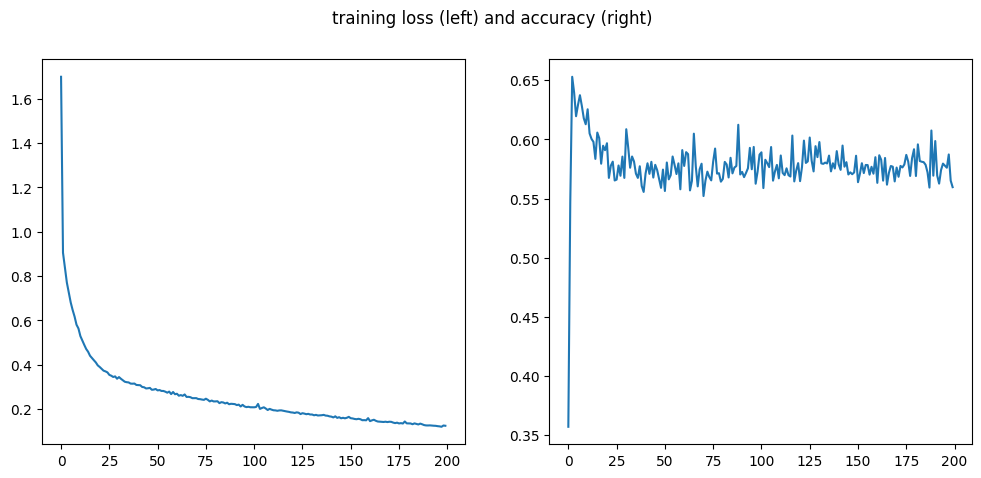

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('training loss (left) and accuracy (right)')
ax1.plot(losses)
ax2.plot(accs)